# MOGDx 

In [1]:
import argparse
import pandas as pd
import numpy as np
import os
import sys  
sys.path.insert(0, './MAIN/')
from utils import *
from GNN_MME import *
from train import *
import preprocess_functions

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold 
import networkx as nx
import torch
from datetime import datetime
import joblib
import warnings
import gc
warnings.filterwarnings("ignore")

print("Finished Library Import \n")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Finished Library Import 



In [2]:
data_input = './../data/raw'
snf_net = 'mRNA_RPPA_DNAm_graph.graphml'
index_col = 'index'
target = 'paper_BRCA_Subtype_PAM50'

Using cuda device
Total = 6.4Gb 	 Reserved = 0.0Gb 	 Allocated = 0.0Gb
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
GCN_MME(
  (encoder_dims): ModuleList(
    (0): Encoder(
      (encoder): Sequential(
        (0): Linear(in_features=29995, out_features=500, bias=True)
        (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=500, out_features=32, bias=True)
        (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=32, out_features=64, bias=True)
      )
    )
    (1): Encoder(
      (encoder): Sequential(
        (0): Linear(in_features=464, out_features=500, bias=True)
        (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=500, out_features=16, bias=True)
        (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_ru

Epoch 00435 | Loss 0.6793 | Train Acc. 0.6575 | Validation Acc. 0.8621 
Epoch 00440 | Loss 0.7156 | Train Acc. 0.6358 | Validation Acc. 0.8621 
Epoch 00445 | Loss 0.6543 | Train Acc. 0.6474 | Validation Acc. 0.8621 
Epoch 00450 | Loss 0.6476 | Train Acc. 0.6720 | Validation Acc. 0.8621 
Epoch 00455 | Loss 0.6657 | Train Acc. 0.6532 | Validation Acc. 0.8621 
Epoch 00460 | Loss 0.6763 | Train Acc. 0.6517 | Validation Acc. 0.8621 
Epoch 00465 | Loss 0.6754 | Train Acc. 0.6387 | Validation Acc. 0.8621 
Epoch 00470 | Loss 0.6477 | Train Acc. 0.6503 | Validation Acc. 0.8563 
Epoch 00475 | Loss 0.6951 | Train Acc. 0.6416 | Validation Acc. 0.8563 
Epoch 00480 | Loss 0.6805 | Train Acc. 0.6445 | Validation Acc. 0.8563 
Epoch 00485 | Loss 0.6481 | Train Acc. 0.6763 | Validation Acc. 0.8621 
Epoch 00490 | Loss 0.6469 | Train Acc. 0.6662 | Validation Acc. 0.8678 
Epoch 00495 | Loss 0.6668 | Train Acc. 0.6402 | Validation Acc. 0.8621 
Epoch 00500 | Loss 0.7113 | Train Acc. 0.6301 | Validation Acc. 

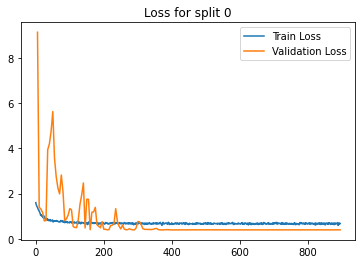

Fold : 1 | Test Accuracy = 0.8387 | F1 = 0.7975 
Total = 6.4Gb 	 Reserved = 4.0Gb 	 Allocated = 1.7Gb
Clearing gpu memory
Total = 6.4Gb 	 Reserved = 1.7Gb 	 Allocated = 1.7Gb
GCN_MME(
  (encoder_dims): ModuleList(
    (0): Encoder(
      (encoder): Sequential(
        (0): Linear(in_features=29995, out_features=500, bias=True)
        (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=500, out_features=32, bias=True)
        (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=32, out_features=64, bias=True)
      )
    )
    (1): Encoder(
      (encoder): Sequential(
        (0): Linear(in_features=464, out_features=500, bias=True)
        (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=500, out_features=16, bias=True)
        (3): BatchNorm1d(16, eps

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# Get GPU device name, else use CPU
print("Using %s device" % device)
get_gpu_memory()

datModalities , meta = data_parsing(data_input , ['mRNA' , 'RPPA' , 'DNAm' ] , target , index_col)

graph_file = data_input + '/../Networks/' + snf_net
g = nx.read_graphml(graph_file)
'''g = network_from_csv('./../data/raw/mRNA_RPPA_graph.csv' , False)
nx.set_node_attributes(g , meta.astype('category').cat.codes , 'label')

graph_nodes= list(g.nodes)

for node in graph_nodes : 
    if node in meta.index : 
        pass
    else : 
        g.remove_node(node)'''

meta = meta.loc[sorted(meta.index)]

skf = StratifiedKFold(n_splits=5 , shuffle=True) 

print(skf)

subjects_list = [list(set(g.nodes) & set(datModalities[mod].index)) for mod in datModalities]
h = [torch.from_numpy(datModalities[mod].loc[subjects_list[i]].to_numpy(dtype=np.float32)).to(device) for i , mod in enumerate(datModalities) ]
MME_input_shapes = [ datModalities[mod].shape[1] for mod in datModalities]

del datModalities
gc.collect()

labels = F.one_hot(torch.Tensor(list(meta.astype('category').cat.codes)).to(torch.int64)).to(device)
output_metrics = []
test_logits = []
test_labels = []
for i, (train_index, test_index) in enumerate(skf.split(meta.index, meta)) :

    model = GCN_MME(MME_input_shapes , [32 , 16 , 32] , 64 , [32]  , len(meta.unique())).to(device)
    print(model)
    print(g)

    train_index , val_index = train_test_split(
        train_index, train_size=0.8, test_size=None, stratify=meta.iloc[train_index]
        )

    loss_plot = train(g, h , subjects_list , train_index , val_index , device ,  model , labels , 2000 , 1e-3 , 100)
    plt.title(f'Loss for split {i}')
    plt.show()
    plt.clf()
    
    test_output_metrics = evaluate(test_index , device , g , h , subjects_list , model , labels )

    print(
        "Fold : {:01d} | Test Accuracy = {:.4f} | F1 = {:.4f} ".format(
        i+1 , test_output_metrics[1] , test_output_metrics[2] )
    )
    
    test_logits.extend(test_output_metrics[-1][test_index])
    test_labels.extend(labels[test_index])
    
    output_metrics.append(test_output_metrics)
    if i == 0 : 
        best_model = model
        best_idx = i
    elif output_metrics[best_idx][1] < test_output_metrics[1] : 
        best_model = model
        best_idx   = i

    get_gpu_memory()
    del model
    gc.collect()
    torch.cuda.empty_cache()
    print('Clearing gpu memory')
    get_gpu_memory()

test_logits = torch.stack(test_logits)
test_labels = torch.stack(test_labels)
    
accuracy = []
F1 = []
i = 0
for metric in output_metrics :
    
    accuracy.append(metric[1])
    F1.append(metric[2])


print("%i Fold Cross Validation Accuracy = %2.2f \u00B1 %2.2f" %(5 , np.mean(accuracy)*100 , np.std(accuracy)*100))
print("%i Fold Cross Validation F1 = %2.2f \u00B1 %2.2f" %(5 , np.mean(F1)*100 , np.std(F1)*100))

confusion_matrix(test_logits , test_labels , meta.astype('category').cat.categories)
plt.title('Test Accuracy = %2.1f %%' % (np.mean(accuracy)*100))

precision_recall_plot , all_predictions_conf = AUROC(test_logits, test_labels , meta)

node_predictions = []
display_label = meta.astype('category').cat.categories
for pred in all_predictions_conf.argmax(1)  : 
    node_predictions.append(display_label[pred])

tst = pd.DataFrame({'Actual' : meta.loc[list(nx.get_node_attributes(g, 'idx').keys())] , 'Predicted' : node_predictions})